# Exploratory Data Analysis

- Long tail of labels

### Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config.global_args import GlobalArgs
from config.data_args import DataArgs
from statsmodels.stats.weightstats import DescrStatsW

# from src.preprocessing.preprocessor import LogPreprocessor

args = DataArgs()

In [14]:
use_columns = ['title_en','description_en','research_fields_en','description_sv','title_sv','research_fields_sv' ,'funding_year'] 
data = pd.read_excel(args.raw_data_path, usecols = use_columns)

# Output first five rows
print(data.info())
print(f'{sum(data["research_fields_en"].str.count("Unclassified"))} research projects are unclassified.')

data.head(1)
data = data[data['research_fields_en'] != 'Unclassified']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59220 entries, 0 to 59219
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_sv            58629 non-null  object 
 1   title_en            56813 non-null  object 
 2   funding_year        52387 non-null  float64
 3   research_fields_en  59220 non-null  object 
 4   research_fields_sv  59220 non-null  object 
 5   description_sv      46770 non-null  object 
 6   description_en      44825 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.2+ MB
None
9289 research projects are unclassified.


In [15]:
data.dropna(subset=['title_sv','description_sv','research_fields_sv']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39553 entries, 1 to 59219
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_sv            39553 non-null  object 
 1   title_en            38574 non-null  object 
 2   funding_year        32829 non-null  float64
 3   research_fields_en  39553 non-null  object 
 4   research_fields_sv  39553 non-null  object 
 5   description_sv      39553 non-null  object 
 6   description_en      33797 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


In [16]:
data.dropna(subset=['title_en','description_en','research_fields_en']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42076 entries, 0 to 59219
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_sv            41946 non-null  object 
 1   title_en            42076 non-null  object 
 2   funding_year        35352 non-null  float64
 3   research_fields_en  42076 non-null  object 
 4   research_fields_sv  42076 non-null  object 
 5   description_sv      33344 non-null  object 
 6   description_en      42076 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.6+ MB


In [6]:
print(f'{sum(data["research_fields_en"].str.count("Unclassified"))} research projects are unclassified.')

data = data.dropna(subset=['title_en','description_en','research_fields_en'])


0 research projects are unclassified.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42076 entries, 0 to 59219
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_sv            41946 non-null  object 
 1   title_en            42076 non-null  object 
 2   funding_year        35352 non-null  float64
 3   research_fields_en  42076 non-null  object 
 4   research_fields_sv  42076 non-null  object 
 5   description_sv      33344 non-null  object 
 6   description_en      42076 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.6+ MB


## Map data to corresponding SCB class

In [8]:
# Load SCB classifications & Preprocess

df_classifications = pd.read_excel(args.raw_classifications_SCB,  index_col=0)

df_classifications['Label_En'] = df_classifications['Label_En'].apply(lambda x: x.strip().lower())
df_classifications['Label_Sv'] = df_classifications['Label_Sv'].apply(lambda x: x.strip().lower())

# df_classifications.rename( columns={'Unnamed: 0':'ID'}, inplace=True)

In [9]:
from src.preprocessing.preprocessor import LogRegPreprocessor

preprocessor = LogRegPreprocessor(model_type='eda')

In [10]:
# Load SCB classifications and retrieve unique label for data
data['label_IDs'] = data['research_fields_en'].apply(lambda x: preprocessor.get_matching_SCB_class_IDs(x, df_classifications))

# Statistics

In [11]:
# Calculate the number of digits for the class id that indicates the level of classification 
df_classifications['class_level'] = df_classifications.index.to_series().apply(lambda x: len(str(x)))

# Count the classes for each level
df_classifications['class_level'].value_counts()

5    260
3     42
1      6
Name: class_level, dtype: int64

Disregarding the level of classification, one research project contains in average 4.65 labels with a standard deviation of $\pm$ 2.28.


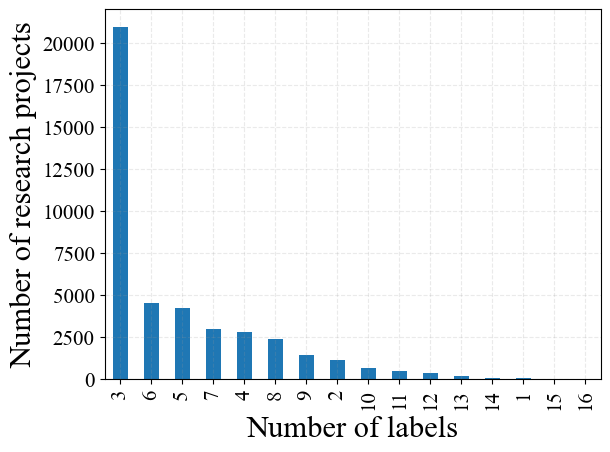

<Figure size 640x480 with 0 Axes>

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.style.use('default')
plt.rc('font',family='Times New Roman') 
plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

counts = data['research_fields_en'].apply(lambda x: len(x.split('|'))).value_counts()
counts.plot.bar( grid=True)
weighted_stats = DescrStatsW(counts.index, weights=counts, ddof=0)

plt.xlabel('Number of labels', fontsize=22)
plt.ylabel('Number of research projects', fontsize=22)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


#title='Distribution - number of labels per research project (all classification levels)',
plt.savefig('reports/figures/4_labels_all.pdf', bbox_inches='tight')
print(f'Disregarding the level of classification, one research project contains in average {round(weighted_stats.mean,2)} labels with a standard deviation of $\pm$ {round(weighted_stats.std,2)}.')

plt.show()
plt.clf()

15.98% of the research projects do not contain information about the year of funding.


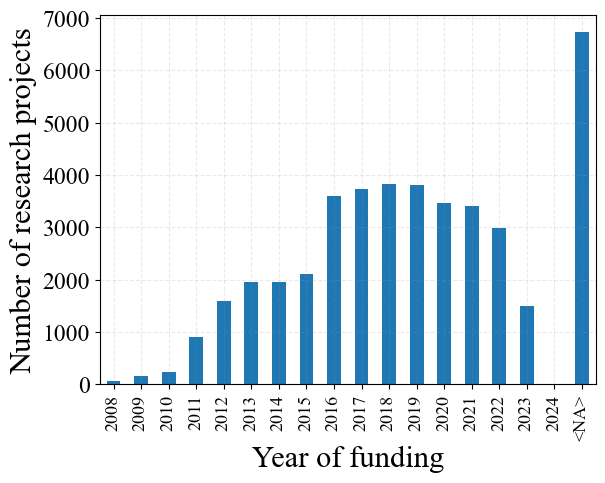

<Figure size 640x480 with 0 Axes>

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.style.use('default')
plt.rc('font',family='Times New Roman') 
plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

funding_years = data['funding_year'].astype('Int64')
counts = funding_years.value_counts(dropna=False).sort_index()

counts.plot.bar( grid=True)


plt.xlabel('Year of funding', fontsize=22)
plt.ylabel('Number of research projects', fontsize=22)
plt.yticks(fontsize=17)
plt.xticks(fontsize=13)

#title='Distribution of year of funding'

plt.savefig('reports/figures/4_years.pdf' , bbox_inches='tight')
proportion_wo_year = 1- funding_years.dropna().value_counts().sum()/counts.sum()

print(f'{round(proportion_wo_year*100,2)}% of the research projects do not contain information about the year of funding.')  
plt.show()
plt.clf()

In [19]:
all_IDs = pd.DataFrame([x for item in data['label_IDs'] for x in item], columns = ['label_IDs'])
all_IDs.value_counts().sort_values()

label_IDs
20404            4
40503            8
30310            8
30501            9
30104           10
             ...  
203           6514
3             8810
5             9245
1            12761
2            19544
Length: 305, dtype: int64

In [20]:
set1 = set(all_IDs['label_IDs'])
set2 = set(df_classifications.index)
missing = list(sorted(set2 - set1))

print(f'The following labels could not be found in the data set:')
for field in missing:
    print(f'{df_classifications["Label_En"].loc[field]}[{field}]')


The following labels could not be found in the data set:
bioethics[20804]
psychology ( excluding applied psychology )[50101]
law ( excluding law and society )[50501]


In [29]:
word_counts = data[['title_en', 'description_en']].apply(lambda x: len(' '.join(x).split()), axis=1)
# Calculate the mean and standard deviation of the number of words
mean_word_count = np.mean(word_counts)
std_word_count = np.std(word_counts)

print(f'mean: {mean_word_count}, standard deviation: {std_word_count}, min: {np.min(word_counts)}, max{np.max(word_counts)} \n {sum(word_counts<20)} data points contain less than 20 words in the text.')

mean: 233.17432740754825, standard deviation: 85.98234440565665, min: 4, max3810 
 79 data points contain less than 20 words in the text.


In [12]:
data['word_count'] = data[['title_en', 'description_en']].apply(lambda x: len(' '.join(x).split()), axis=1)
# data['title_en'].apply(lambda x: len(x.split())) 
print(sum(data['word_count']>512))
# Sort the DataFrame by the number of words in the 'text' column in ascending order
df = data.sort_values(by='word_count', ascending=False)
df.head(10)

537


,title_sv,title_en,funding_year,research_fields_en,research_fields_sv,description_sv,description_en,word_count
58712,Harbours - silting and environmental sedimento...,Harbours - silting and environmental sedimento...,NaN,Chemical Sciences | Computer and Information S...,Annan data- och informationsvetenskap | Data- ...,"1.Identification of the sediment sources, tran...","1.Identification of the sediment sources, tran...",3810
58838,"Interactions at the molecular level, of biolog...","Interactions at the molecular level, of biolog...",NaN,Basic Medicine | Biochemistry and Molecular Bi...,Annan materialteknik | Biokemi och molekylärbi...,The present project constitutes a further qual...,The present project constitutes a further qual...,3275
59041,CHARACTERISTICS OF RADON- AND THORON DAUGHTERS...,CHARACTERISTICS OF RADON- AND THORON DAUGHTERS...,NaN,Atom and Molecular Physics and Optics | Chemic...,Annan matematik | Atom- och molekylfysik och o...,<br/>A radon chamber was designed to study the...,<br/>A radon chamber was designed to study the...,2555
58956,Immunotoxicology of drugs and biotechnology-de...,Immunotoxicology of drugs and biotechnology-de...,NaN,Basic Medicine | Clinical Medicine | Genetics ...,Farmaceutiska vetenskaper | Genetik | Hälsovet...,The purpose of this project was to utilise rec...,The purpose of this project was to utilise rec...,2371
56597,DEVELOPMENT OF A COMPREHENSIVE DECISION SUPPOR...,DEVELOPMENT OF A COMPREHENSIVE DECISION SUPPOR...,NaN,"Astronomy, Astrophysics and Cosmology | Chemic...",Annan data- och informationsvetenskap | Annan ...,Task description <br/><br/>The purpose of the ...,Task description <br/><br/>The purpose of the ...,2335
58714,Predicting the effects of environmental change...,Predicting the effects of environmental change...,NaN,Behavioural Sciences Biology | Biological Scie...,Annan geovetenskap och miljövetenskap | Biolog...,The chief objectives of this four-year project...,The chief objectives of this four-year project...,2178
58875,Development plasma technology continuous proce...,Development plasma technology continuous proce...,NaN,Biochemistry and Molecular Biology | Biologica...,Annan matematik | Biokemi och molekylärbiologi...,<br/>The analytical and experimental work of t...,<br/>The analytical and experimental work of t...,1614
58717,Sized-based tools for managing freshwater fish...,Sized-based tools for managing freshwater fish...,NaN,Behavioural Sciences Biology | Biological Scie...,Annan geovetenskap och miljövetenskap | Annan ...,- To implement a monitoring programme for fish...,- To implement a monitoring programme for fish...,1502
58331,"European prospective study of environment, all...","European prospective study of environment, all...",NaN,Clinical Medicine | Health Sciences | Medical ...,Annan klinisk medicin | Hälsovetenskap | Klini...,<br/>1. Objectives and expected achievements <...,<br/>1. Objectives and expected achievements <...,1468
59016,Biotechnology of extremophiles,Biotechnology of extremophiles,NaN,Biochemistry and Molecular Biology | Biologica...,Biokemi och molekylärbiologi | Biologi (Medici...,<br/>Extremophiles have tremendous potential i...,<br/>Extremophiles have tremendous potential i...,1437


# Analysis long tail of label distribution in sample

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_26351/89578783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 1. 6 labels were used out of 6 possible ones.


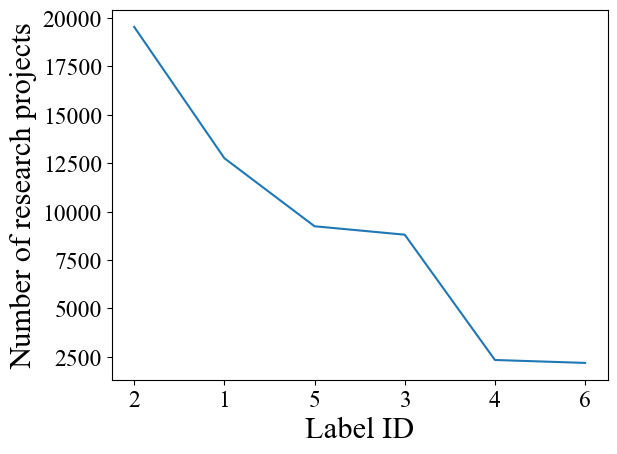

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_26351/89578783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 3. 42 labels were used out of 42 possible ones.


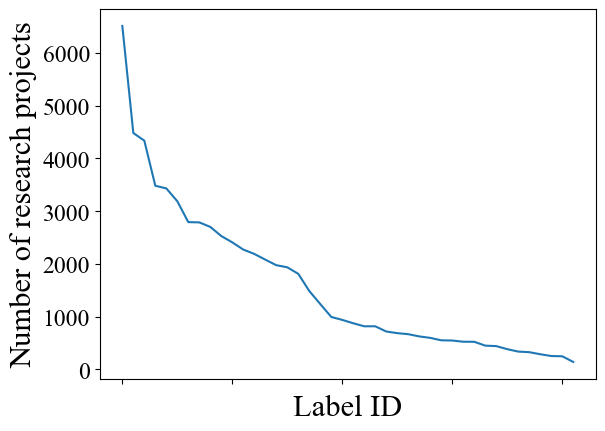

/var/folders/10/g950pxln7y5c3bn_j_q00lc40000gn/T/ipykernel_26351/89578783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')


Plot of all labels found with a classification level of 5. 257 labels were used out of 260 possible ones.


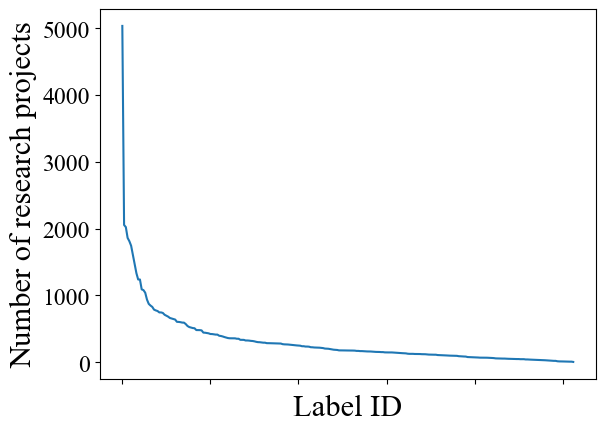

<Figure size 640x480 with 0 Axes>

In [28]:

k = 1
for i, all_label in zip([1,3,5], [6,42,260]):

    fig = plt.figure()
    # Filter the data depending on the level of classification 
    
    filtered_df = all_IDs[all_IDs['label_IDs'].apply(lambda x: True if len(str(x)) == i else False)]
    filtered_df['label_IDs'] = filtered_df['label_IDs'].astype('int')
    
    print(f"Plot of all labels found with a classification level of {i}. {filtered_df.value_counts().size} labels were used out of {all_label} possible ones.")
    
    ax = fig.add_subplot()
    plt.style.use('default')
    plt.rc('font',family='Times New Roman') 
    plt.grid(visible=True, which='major', color='#999999', linestyle='--', alpha=0.2)

  
    counts = filtered_df.value_counts()
    counts.plot() 
    if i == 1:
        x = [i[0] for i in counts.index.values.tolist()]
        xi = list(range(len(x)))
        plt.xticks(xi, x)
    else:
        ax.set_xticklabels([])
    
    plt.xlabel('Label ID', fontsize=22)
    plt.ylabel('Number of research projects', fontsize=22)
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17)

    plt.savefig(f'reports/figures/labels_level_{i}.pdf', bbox_inches='tight')

    plt.show()
    k +=1
plt.clf()

# Analysis labels for each data point

In [35]:
level_IDs = list()
for value in data['label_IDs']:
    label_level = list()
    for item in value:
        label_level.append(len(str(item)))
    level_IDs.append(label_level)

In [36]:
level_ids = pd.DataFrame()
k = 1
for i, name in zip([1,3,5],['level_1','level_2','level_3']):
    temp_list = list(x.count(i) for x in level_IDs)
    level_ids[name] = temp_list
    print(f" A research project has in average {round(level_ids[name].mean(),2)} labels of level {k} with a standard deviation of {round(level_ids[name].std(),2)}")
    #level_ids[name].value_counts().plot(kind ='bar', title= name)   
    plt.show()
    k +=1

 A research project has in average 1.3 labels of level 1 with a standard deviation of 0.57
 A research project has in average 1.58 labels of level 2 with a standard deviation of 0.87
 A research project has in average 1.92 labels of level 3 with a standard deviation of 1.17


In [ ]:
all_IDs = pd.DataFrame([x for item in data['label_IDs'] for x in item], columns = ['label_IDs'])